In [66]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
import math
import plotly.plotly as py
import plotly
from dateutil import parser

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import chi2

### Packages for classification ###
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, tree
import sklearn.linear_model
from sklearn.ensemble import RandomForestRegressor

### Packages for metric calculation ###
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

In [67]:
%matplotlib inline

#### Load Datasets 

In [68]:
loans = pd.read_csv('../data/kiva_loans.csv')
kiva_mpi = pd.read_csv('../data/kiva_mpi_region_locations.csv')
loan_theme_id = pd.read_csv('../data/loan_theme_ids.csv')
loan_theme_region = pd.read_csv('../data/loan_themes_by_region.csv')

#### Data Exploration

The 'kiva_loans' dataset has details of every loan given by Kiva in the last 2 years. Each loan is identified by an id and contains details like amount of the loan (in USD), purpose which the loan was given, date on which the loan was given out, partner involved, number of lenders etc. The dataset has information on a total of 671205 loans.

In [69]:
print(loans.shape)
loans.head()

(671205, 20)


,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


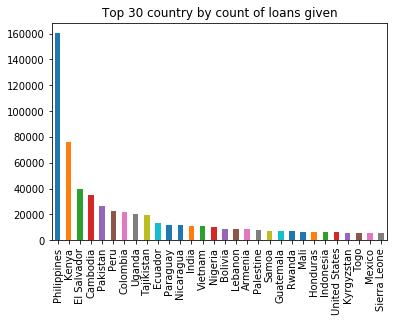

In [70]:
country_dist = loans.country.value_counts()
country_dist.nlargest(30).plot.bar(title="Top 30 country by count of loans given", x="Country", y="Count of Loans")


Text(0.5, 0, 'Loan Amount in USD')

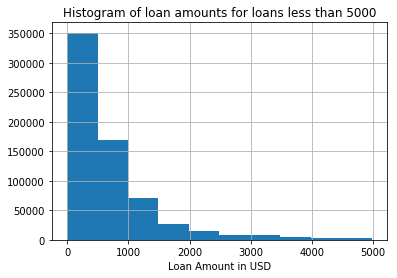

In [71]:
loans[loans.funded_amount < 5000].hist(column='funded_amount')
plt.title("Histogram of loan amounts for loans less than 5000")
plt.xlabel("Loan Amount in USD")


In [72]:
loans.repayment_interval.value_counts()#.plot.bar(title="Repayment Interval")

monthly      342717
irregular    257158
bullet        70728
weekly          602
Name: repayment_interval, dtype: int64

In [73]:
loans[loans.funded_amount > 5000].shape

(8479, 20)

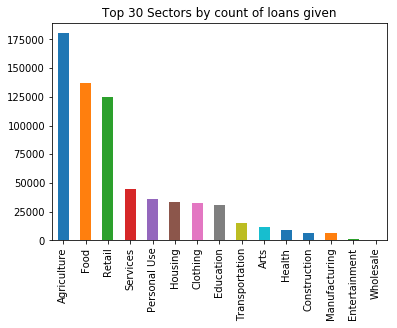

In [74]:
sector_dist = loans.sector.value_counts()
sector_dist.nlargest(30).plot.bar(title="Top 30 Sectors by count of loans given")


In [75]:
loans['posted_time'] = pd.to_datetime(loans['posted_time'])
loans['disbursed_time'] = pd.to_datetime(loans['disbursed_time'])
loans['funded_time'] = pd.to_datetime(loans['funded_time'])


In [76]:
loans.borrower_genders = loans.borrower_genders.str.split().str[0].str.replace(",", "")

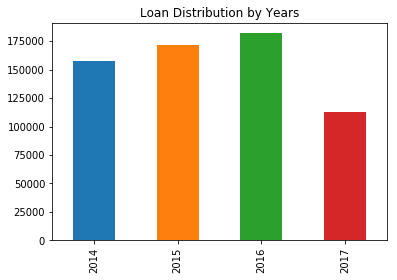

In [77]:
time_dist = loans['funded_time'].dt.year.fillna(0).astype(int).value_counts()
time_dist.drop(labels=[0]).sort_index().plot.bar( title="Loan Distribution by Years")



In [78]:
## Sector distribution by countries
loans.groupby(['country', 'sector']).count()['id'].head()

country      sector      
Afghanistan  Arts              2
Albania      Agriculture     719
             Arts              5
             Clothing         87
             Construction     30
Name: id, dtype: int64

#### kiva_mpi_region_locations

The 'kiva_mpi_region_locations' dataset is the ground-truth dataset which contains information about the MPI (Multi-dimensional poverty index) of the respective regions under study.Each region is defined by its name, country and geo-coordinates. The dataset reports the MPI of 2772 regions spread across 6 of the world-regions

In [79]:
print(kiva_mpi.shape)
kiva_mpi.head()

(2772, 9)


,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [80]:
len(loans.region.value_counts())

12695

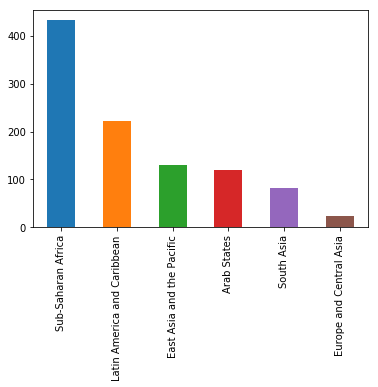

In [81]:
kiva_mpi.world_region.value_counts().plot.bar()

#### loan_theme_ids

The 'loan_theme_ids' dataset records the general theme type of each loan (identified by its ID) and its respective partner ID. The dataset has 779092 records. 

In [82]:
print(loan_theme_id.shape)
loan_theme_id.head()


(779092, 4)


,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.0
1,640322,a1050000000skGl,General,151.0
2,641006,a1050000002X1ij,Higher Education,160.0
3,641019,a1050000002X1ij,Higher Education,160.0
4,641594,a1050000002VbsW,Subsistence Agriculture,336.0


#### Loan_themes_by_region

The 'loan_themes_by_region' dataset has details on the partner associated with the loans in the previous datasets. For every partner, it contains details on every theme type, the amount lent by them and details of the area from which these partners operate. The dataset contains 15,736 records on 302 partners

In [83]:
print("Shape:", loan_theme_region.shape)
print("Number of Partners: ", len(loan_theme_region['Partner ID'].unique()))
loan_theme_region.head()

Shape: (15736, 21)
Number of Partners:  302


,Partner ID,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,geocode_old,ISO,...,amount,LocationName,geocode,names,geo,lat,lon,mpi_region,mpi_geo,rural_pct
0,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Banteay Meanchey,"(13.75, 103.0)",KHM,...,450,"Banteay Meanchey, Cambodia","[(13.6672596, 102.8975098)]",Banteay Meanchey Province; Cambodia,"(13.6672596, 102.8975098)",13.667260,102.897510,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
1,9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Battambang Province,NaN,KHM,...,20275,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
2,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Battambang Province,NaN,KHM,...,9150,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
3,9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,604950,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0
4,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000002X1Uu,Sanitation,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,275,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0


In [84]:
loan_theme_region.columns

Index(['Partner ID', 'Field Partner Name', 'sector', 'Loan Theme ID',
       'Loan Theme Type', 'country', 'forkiva', 'region', 'geocode_old', 'ISO',
       'number', 'amount', 'LocationName', 'geocode', 'names', 'geo', 'lat',
       'lon', 'mpi_region', 'mpi_geo', 'rural_pct'],
      dtype='object')

In [85]:
loan_theme_region.drop(['Field Partner Name', 
       'Loan Theme Type', 'country', 'forkiva', 'amount', 'LocationName', 'geocode', 'names', 'geo', 'lat',
       'lon', 'mpi_region', 'mpi_geo', 'rural_pct'], axis=1, inplace=True)

In [86]:
tmp1 = pd.merge(loans, kiva_mpi, on=['region', 'country'], how='left')
tmp2 = pd.merge(tmp1, loan_theme_id, on=['id'], how='left')


In [87]:
tmp1.shape

(671205, 27)

In [88]:
tmp2.dropna(subset=['MPI'], inplace=True)

In [89]:
tmp2.shape

(50955, 30)

In [90]:
tmp2.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date', 'LocationName', 'ISO', 'world_region', 'MPI', 'geo', 'lat',
       'lon', 'Loan Theme ID', 'Loan Theme Type', 'Partner ID'],
      dtype='object')

In [91]:
data = pd.merge(tmp2, loan_theme_region, on=['Partner ID', 'Loan Theme ID', 'region', 'sector', 'ISO'], how='left')

In [92]:
data.shape

(50955, 32)

<Figure size 2880x2880 with 0 Axes>

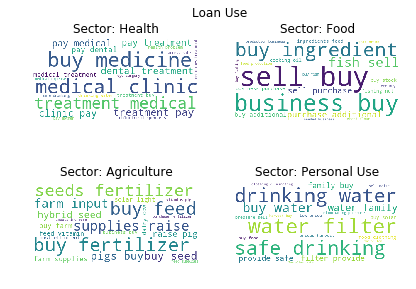

<Figure size 2880x2880 with 0 Axes>

In [113]:
from wordcloud import WordCloud
from nltk.corpus import stopwords 

STOPWORDS = set(stopwords.words('english')) 

# Plot word clouds
plt.subplot(221).set_title("Sector: Health")
wc = WordCloud(background_color='white', stopwords=STOPWORDS,max_words=20).generate(" ".join(loans.loc[loans['sector'] == 'Health'].use.astype(str)))
plt.imshow(wc)
plt.axis('off')

plt.subplot(222).set_title("Sector: Food")
wc = WordCloud(background_color='white', stopwords=STOPWORDS,max_words=20).generate(" ".join(loans.loc[loans['sector'] == 'Food'].use.astype(str)))
plt.imshow(wc)
plt.axis('off')

plt.subplot(223).set_title("Sector: Agriculture")
wc = WordCloud(background_color='white', stopwords=STOPWORDS,max_words=20).generate(" ".join(loans.loc[loans['sector'] == 'Agriculture'].use.astype(str)))
plt.imshow(wc)
plt.axis('off')

plt.subplot(224).set_title("Sector: Personal Use")
wc = WordCloud(background_color='white', stopwords=STOPWORDS,max_words=20).generate(" ".join(loans.loc[loans['sector'] == 'Personal Use'].use.astype(str)))
plt.imshow(wc)
plt.axis('off')

plt.suptitle("Loan Use")
plt.tight_layout(pad=0.4, w_pad=0.0, h_pad=2.0, rect=[0, 0, 0.95, 0.95])
plt.figure(figsize=(40,40))

In [31]:
data.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date', 'LocationName', 'ISO', 'world_region', 'MPI', 'geo', 'lat',
       'lon', 'Loan Theme ID', 'Loan Theme Type', 'Partner ID', 'geocode_old',
       'number'],
      dtype='object')

In [32]:
loans.borrower_genders.value_counts()

female    513643
male      153341
Name: borrower_genders, dtype: int64

In [33]:
data.MPI.isna().value_counts()

False    50955
Name: MPI, dtype: int64

In [34]:
data.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,world_region,MPI,geo,lat,lon,Loan Theme ID,Loan Theme Type,Partner ID,geocode_old,number
0,653359,600.0,600.0,Machinery Rental,Services,to invest in working capital and to maintain g...,NI,Nicaragua,Leon,NIO,...,Latin America and Caribbean,0.031,"(28.3998551, 83.6895693)",28.399855,83.689569,a1050000000wf00,General,96.0,NaN,NaN
1,653432,550.0,550.0,Personal Expenses,Personal Use,to buy a cradle and household items for his yo...,PE,Peru,Ica,PEN,...,Latin America and Caribbean,0.009,"(-14.07546, -75.7341811)",-14.075460,-75.734181,a1050000000wf0k,General,139.0,NaN,NaN
2,653410,1075.0,1075.0,Transportation,Transportation,to pay for general maintenance on his vehicle.,PE,Peru,Ica,PEN,...,Latin America and Caribbean,0.009,"(-14.07546, -75.7341811)",-14.075460,-75.734181,a1050000000wf0k,General,139.0,NaN,NaN
3,653373,1000.0,1000.0,Grocery Store,Food,to invest in working capital and to provide hi...,NI,Nicaragua,Leon,NIO,...,Latin America and Caribbean,0.031,"(28.3998551, 83.6895693)",28.399855,83.689569,a1050000000wf00,General,96.0,NaN,NaN
4,653166,600.0,600.0,Cattle,Agriculture,To buy a calf to raise.,KH,Cambodia,Phnom Penh,USD,...,East Asia and the Pacific,0.026,"(11.5448729, 104.8921668)",11.544873,104.892167,a1050000000wezV,General,61.0,NaN,NaN


#### Feature Engineering

In [99]:
data['world_region'] = pd.Series(LabelEncoder().fit_transform(data.world_region.astype('str')))
data['repayment_interval'] = pd.Series(LabelEncoder().fit_transform(data.repayment_interval.astype('str')))
data['country_code'] = pd.Series(LabelEncoder().fit_transform(data.country_code.astype('str')))
data['activity'] = pd.Series(LabelEncoder().fit_transform(data.activity.astype('str')))
data['sector'] = pd.Series(LabelEncoder().fit_transform(data.sector.astype('str')))
#data['region'] = pd.Series(LabelEncoder().fit_transform(data.region.astype('str')))
data['borrower_genders'] = pd.Series(LabelEncoder().fit_transform(data.borrower_genders.astype('str')))
data['currency'] = pd.Series(LabelEncoder().fit_transform(data.currency.astype('str')))
data['Loan Theme Type'] = pd.Series(LabelEncoder().fit_transform(data['Loan Theme Type'].astype('str')))

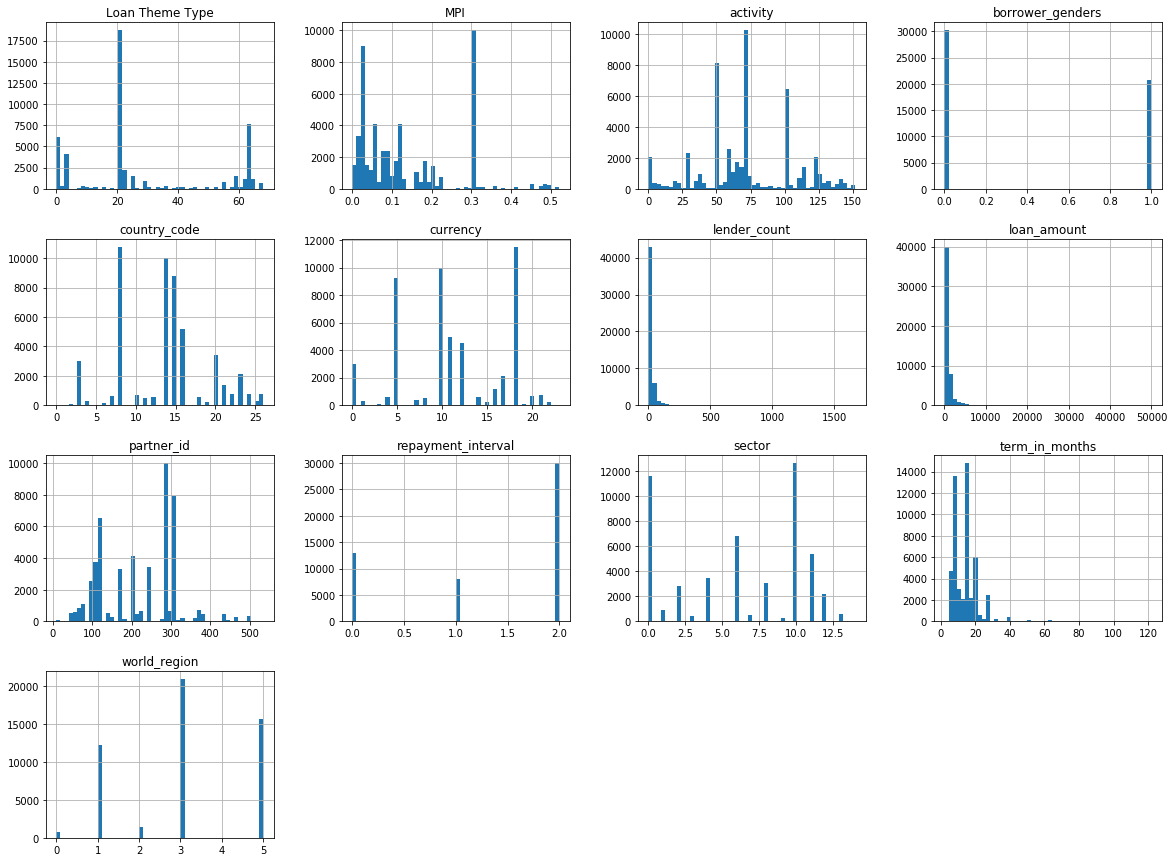

In [100]:
analysis = data.drop(columns=['geo', 'id', 'lat', 'lon', 'LocationName', 'Partner ID', 'funded_amount', 'ISO', 'date', 'tags', 'posted_time', 'disbursed_time', 'funded_time', 'geocode_old', 'Loan Theme ID', 'number'], axis=1)
analysis.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [101]:
data = pd.get_dummies(data, columns=['world_region', 'repayment_interval', 'country', 'activity', 'sector', 
                                     'borrower_genders', 'Loan Theme Type'])


In [102]:
data.columns

Index(['id', 'funded_amount', 'loan_amount', 'use', 'country_code', 'region',
       'currency', 'partner_id', 'posted_time', 'disbursed_time',
       ...
       'Loan Theme Type_59', 'Loan Theme Type_60', 'Loan Theme Type_61',
       'Loan Theme Type_62', 'Loan Theme Type_63', 'Loan Theme Type_64',
       'Loan Theme Type_65', 'Loan Theme Type_66', 'Loan Theme Type_67',
       'Loan Theme Type_68'],
      dtype='object', length=300)

In [103]:
data['year']=pd.to_datetime(data['date'],format='%Y-%m-%d').dt.year
data['month']=pd.to_datetime(data['date'],format='%Y-%m-%d').dt.month

In [104]:
data['year'].value_counts()

2014    15323
2016    13857
2015    13212
2017     8563
Name: year, dtype: int64

In [105]:
data['time_taken'] = (data['funded_time'] - data['posted_time']).dt.days
data.drop(columns=['geo', 'id', 'lat', 'lon', 'country_code', 'currency',
                   'region', 'Partner ID', 'use', 'funded_amount', 'LocationName', 'ISO', 
                   'date', 'tags', 'posted_time', 'disbursed_time', 'funded_time', 'geocode_old', 'Loan Theme ID', 'number'], axis=1, inplace=True)

data.dropna(inplace=True)

In [106]:
X = data.drop(columns=['MPI'])

In [107]:
y = data['MPI'].astype('float')

#### Modelling & Evaluation

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [109]:
regr = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=80)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.9038215497139392

In [110]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
y_pred = regr.predict(X_test)
rf_mse = mean_squared_error(y_pred, y_test)
rf_rmse = np.sqrt(rf_mse)
print('Random Forest RMSE: %.4f' % rf_rmse)

Random Forest RMSE: 0.0370


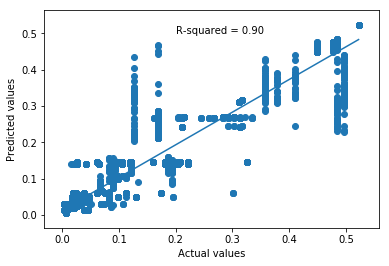

In [111]:
r_squared = regr.score(X_test, y_test)
plt.scatter(y_test,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))

plt.text(0.2,0.5, 'R-squared = %0.2f' % r_squared)
plt.show()

In [63]:
feature_labels = X_train.columns
importance = regr.feature_importances_
feature_indexes_by_importance = importance.argsort()[:len(importance)]
for index in reversed(feature_indexes_by_importance):
    print('{}-{:.3f}%'.format(feature_labels[index], (importance[index]*100.00)))

country_Nigeria-55.851%
world_region_Latin America and Caribbean-11.480%
country_Sierra Leone-10.608%
country_Timor-Leste-5.404%
partner_id-3.891%
country_Mali-3.622%
world_region_Sub-Saharan Africa-2.820%
country_Malawi-1.937%
country_Guatemala-1.139%
loan_amount-0.698%
term_in_months-0.639%
country_Nicaragua-0.385%
country_Haiti-0.275%
time_taken-0.247%
Loan Theme Type_Coffee Production-0.212%
month-0.137%
country_Honduras-0.084%
year-0.083%
Loan Theme Type_Finance to Cooperative-0.082%
lender_count-0.080%
sector_Food-0.054%
activity_Retail-0.043%
repayment_interval_monthly-0.026%
borrower_genders_female-0.018%
repayment_interval_irregular-0.018%
activity_Beverages-0.015%
country_Mongolia-0.015%
activity_Fish Selling-0.013%
activity_Textiles-0.011%
activity_Fruits & Vegetables-0.008%
borrower_genders_male-0.006%
activity_Phone Accessories-0.006%
activity_Clothing-0.006%
sector_Construction-0.006%
activity_General Store-0.005%
activity_Food Stall-0.005%
activity_Quarrying-0.005%
activ

In [64]:
# Linear Reegression
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.8943921123485812

In [112]:
# Random Forest with Cross-Validation
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=123)
nb_rf_result = cross_validate(rf, X, y, cv=4)
print(nb_rf_result)

{'fit_time': array([28.232126  , 29.0857501 , 27.01552415, 25.73513412]), 'score_time': array([0.17609119, 0.12294698, 0.06970787, 0.14268994]), 'test_score': array([0.89456962, 0.8940899 , 0.9318361 , 0.8495194 ]), 'train_score': array([0.93179944, 0.92939003, 0.91928096, 0.94763219])}
